In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

X_train, y_train = train_data[0::, 1::], train_data[0::, 0]
X_test, y_test = test_data[0::, 1::], test_data[0::, 0]

# Взвешенное голосование методов ближайшего соседа, градиентного бустинга с логистической функцией потерь (базовый алгоритм CART) и логистической регресcии.

In [2]:
class CART():
    def __init__(self, max_depth=3):
        # глубина
        self.max_depth = max_depth
        # левое поддерево
        self.left = None
        # правое поддерево
        self.right = None
        # индекс признака для разбиения
        self.feature_idx = -1
        self.feature_threshold = 0
        # значение в листе
        self.value = 0

    def mse(self, y):
        return ((y - y.mean()) ** 2).sum()        
        
    def error(self, y):
        return self.mse(y)
    
    def fit(self, X, y):
        self.value = y.mean()
                
        #критерий останова
        if self.max_depth < 1:
            return
        
        #размер обучающей выборки
        n_samples = X.shape[0]
        
        best_impurity = None

        #поиск признака для разбиения
        
        """
        Чтобы найти лучший split, в цикле просматриваем все признаки и рассматриваем среднее двух соседних значений 
        в отсортированном признаке как возможные thresholds - точки разбиения. Рассчитываем impurity 
        для split, сгенерированного конкретной парой feature/threshold,
        и возвращаем пару с наименьшиим признаком.
        """
        
        for f in range(X.shape[1]):
            # индексы элементов, отсортированные по значениям признака f
            idxs = np.argsort(X[:, f])
            
            sum_left = y.sum()
            sum_right = 0

            sum_left_square = (y ** 2).sum()
            sum_right_square = 0
            
            # число элементов в левом и правом поддеревьях
            N_left = n_samples
            N_right = 0
            
            #номер значения для разделения признака
            thres = 0
            
            # поиск наилучшего значения для разделения f 
            while thres < n_samples - 1:
                N_left -= 1
                N_right += 1
                
                # индекс объекта, у которого признак с индексом thres
                idx = idxs[thres]
                
                # значение объекта с индексом idx
                x = X[idx, f]
                
                sum_left -= y[idx]
                sum_right += y[idx]        
                new_error = -((sum_left - sum_left/N_left)**2)/N_left - ((sum_right - sum_right/N_right)**2)/N_right
                
                # Следующая проверка нужна, чтобы убедиться, что мы не пытаемся
                # разделить 2 точки с совпадающими значениями для этого признака,
                # так как они оба должны оказаться в разбиении на одной стороне. 
                if thres < n_samples - 1 and x == X[idxs[thres + 1], f]:
                    thres += 1
                    continue

                if self.feature_idx == -1 or new_error < best_impurity:
                    self.feature_idx = f
                    self.feature_threshold = (X[idx, f] + X[idxs[thres + 1], f])/2
                    best_impurity = new_error
                thres += 1
        if self.feature_idx == -1:
            return

        
        # индексы примеров для правого и левого поддеревьев
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        # Рекурсивно делим, пока не достигнем максимальной глубины.
        self.left = CART(self.max_depth - 1)
        self.right = CART(self.max_depth - 1)
           
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
    
        
    def _predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left._predict(x)
        else:
            return self.right._predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self._predict(X[i])
            
        return y

In [3]:
myclf = CART(max_depth=1)
myclf.fit(X_train, y_train)
y_pred = myclf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12446198984602179

In [4]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12446198984602179

![Title](./dsmail-2-21.png)

![Title](./dsmail-2-22.png)

![Title](./dsmail-2-23.png)

Для нахождения коэффициента $b = argmin_b \sum_{j=1}^{N}L(y_j, h_{i-1}(x)+ b a_i(x_j))$ воспользуемся методом Ньютона.


$$f' = \frac {\partial L}{\partial b} = \sum_{j=1}^{N} a_i(x_j) (y_j - \sigma (h_{i-1}(x_j) + b a_i(x_j)))$$
$$f'' = \frac {\partial^2 L}{\partial b^2} = -\sum_{j=1}^{N} a_i^2(x_j) \sigma(1 - \sigma)$$

$$b_k = b_{k-1} - \frac{f'}{f''}$$



In [5]:
from tqdm import tqdm

    
#порог для классификации
THR_value = 0.5
    
class MyGradientBoosting:

    
    def __init__(self, n_estimators=100, learning_rate=0.01, max_depth=3, base_model=CART, subsampling=False):
        self.n_estimators = n_estimators #количество моделей
        self.max_depth = max_depth #глубина деревьев
        self.learning_rate = learning_rate #для shrinkage
        self.base_model = base_model #класс моделей
        
        # список коэффициентов при моделях
        self.b = []
        # список моделей
        self.a = []
        
        self.staged_losses = []
        #использовать ли subsampling (подвыборка из наших обучающих данных без возвращения)
        self.subsampling = subsampling

    def sigmoid(self, h):
        return 1/(1 + np.exp(-h))

    def antigrad(self, y, h):
        return  (y - self.sigmoid(h))
    
    def log_loss(self, y, y_pred):
        
        sigma = self.sigmoid(y_pred)
        loss = -np.sum(y*np.log(sigma) + (1 - y)*np.log(1-sigma))
        
        return loss

    # как в sklearn  
    #https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/ensemble/_gb_losses.py
    def sklearn_loss(self, y, y_pred):        
        return -2 * np.mean((y * y_pred) - np.logaddexp(0, y_pred))
    
    def calc_b_i(self, h, a, y):
        b = 0
        f1 = 10
        eps = 0.001

        while np.abs(f1) > eps:
            Hba = h + b * a
            sigma = self.sigmoid(Hba)
            # первая производная
            f1 = np.sum(a*(- y + sigma))
            # вторая производная
            f2 = np.sum(a*a*sigma*(1-sigma))
            delta = f1/f2
            b = b - delta

        return b
    
    def fit(self, X, y):
        # инициализируем предсказание нулями
        h = np.zeros(y.shape[0])
        
        #цикл по количеству моделей
        for i in tqdm(range(self.n_estimators)):

            g_i = self.antigrad(y, h)
            # вводим i-ую модель 
            a_i = self.base_model(max_depth=self.max_depth)

            # строим i-ую модель на ответах g_i
            if self.subsampling:
            # subsampling
                inds = np.random.choice(X.shape[0], int(0.5*X.shape[0]), replace=False)
                a_i.fit(X[inds], g_i[inds])
            else:
                a_i.fit(X, g_i)

            #предсказание i-ой модели
            a_i_pred = a_i.predict(X)
            
            #вычислим коэффициент для новой модели
            b_i = self.calc_b_i(h, a_i_pred, y) * self.learning_rate
            
            
            self.b.append(b_i)
            self.a.append(a_i)
            
            #обновим h - линейную комбинацию предсказаний моделей 
            h = h + b_i * a_i_pred

            self.staged_losses.append(self.log_loss(y, h))
        return self
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        y_pred = np.where(y_pred_proba < THR_value, 0, 1)
        return y_pred
    
    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
        return self.sigmoid(y_pred)

    def staged_decision_function(self, X):
        y_preds = [None] * self.n_estimators
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
            y_preds[i] = y_pred
        return y_preds

In [6]:
MAX_DEPTH = 1

In [7]:
clf_gb_sklearn = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, 
                                 max_depth=MAX_DEPTH, criterion='mse')
clf_gb_sklearn.fit(X_train, y_train)
y_pred_sklearn = clf_gb_sklearn.predict(X_test)
f1_score(y_test, y_pred_sklearn)

0.9690268189871097

In [8]:
my_gb0 = MyGradientBoosting(learning_rate=0.1, n_estimators=500, 
                         base_model=CART, max_depth=MAX_DEPTH)
my_gb0.fit(X_train, y_train)
y_pred_my0 = my_gb0.predict(X_test)
f1_score(y_test, y_pred_my0)

100%|██████████| 500/500 [22:28<00:00,  2.70s/it]


0.9686432406051733

In [9]:
my_gb1 = MyGradientBoosting(learning_rate=0.1, n_estimators=500, 
                         base_model=CART, max_depth=MAX_DEPTH, subsampling=True)
my_gb1.fit(X_train, y_train)
y_pred_my1 = my_gb1.predict(X_test)
f1_score(y_test, y_pred_my1)

100%|██████████| 500/500 [11:07<00:00,  1.34s/it]


0.9705143137375098

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [11]:
class MyKNeighborsClassifier():
    
    def __init__(self,n_neighbors=2):
        self.k=n_neighbors

    def fit(self, X, y):
        if y.shape[0]!=X.shape[0]:
            print ("wrong number")
        Xnp=np.array(X,dtype=float)
        self.X=Xnp
        self.y=y
        self.classes = np.unique(y)
        self.n_samples = Xnp.shape[0]
        self.n_features = Xnp.shape[1]
          
   
    def  predict(self,X):
        res=np.zeros(np.shape(X)[0],dtype=int)
        a=spatial.distance.cdist(X,self.X,metric='minkowski')
        ind=np.argpartition(a,self.k-1,axis=1)[:,:self.k]
        return stats.mode(self.y[ind],axis=1)[0].ravel()
    
    def score(self,X, y):
        return np.mean(self.predict(X)==y)

In [12]:
n_neighbors_param = 3

my_KNN = MyKNeighborsClassifier(n_neighbors=n_neighbors_param)
my_KNN.fit(X_train, y_train)

In [13]:
clf_KNN = KNeighborsClassifier(n_neighbors=n_neighbors_param, algorithm='brute')
clf_KNN.fit(X_train, y_train)


KNeighborsClassifier(algorithm='brute', n_neighbors=3)

In [14]:
y_pred_myKNC = my_KNN.predict(X_test)

In [15]:
f1_score(y_test, y_pred_myKNC)

0.9586713510060684

In [16]:
y_pred_KNCsklearn = clf_KNN.predict(X_test)
f1_score(y_test, y_pred_KNCsklearn)

0.9586713510060684

In [17]:
class LogisticRegressionClassifier():
    
    def __init__(self, num_steps = 50000, learning_rate = 5e-5, add_intercept = False):
        self.num_steps=num_steps
        self.learning_rate=learning_rate
        self.add_intercept=add_intercept
        
        # список весов
        self.weights = []
    
    def log_likelihood(self, features, target, weights):
        scores = np.dot(features, weights)
        ll = -np.sum( target*scores - np.log(1 + np.exp(scores)) )
        return ll

    def sigmoid(self, scores):
        return 1 / (1 + np.exp(-scores))
    
    def fit(self, features, target):
        if self.add_intercept:
            intercept = np.ones((features.shape[0], 1))
            features = np.hstack((intercept, features))

        self.weights = np.zeros(features.shape[1])
    
        for step in range(self.num_steps):
            scores = np.dot(features, self.weights)

            predictions = self.sigmoid(scores)

            # Обновим веса с помощью градиента логистической функции
            output_error_signal = target - predictions
        
            gradient = np.dot(features.T, output_error_signal)
            self.weights += self.learning_rate * gradient

            if step % 10000 == 0:
                print(self.log_likelihood(features, target, self.weights))
                   
    def  predict(self,X):
        if self.add_intercept:
            final_scores = np.dot(np.hstack((np.ones((X.shape[0], 1)), X)), self.weights)
        else:
            final_scores = np.dot(X, self.weights)
        return np.round(self.sigmoid(final_scores))
    
    def score(self, X, y):
        return np.mean(self.predict(X)==y)



In [18]:
my_LogReg = LogisticRegressionClassifier(add_intercept = True)
%time my_LogReg.fit(X_train, y_train)


4861.418113997619
856.6999057696439
820.5078369264809
804.9912388045814
796.2459242156624
CPU times: user 58.7 s, sys: 1.9 s, total: 1min
Wall time: 30.4 s


In [19]:
from sklearn.linear_model import LogisticRegression

clf_LogReg = LogisticRegression(fit_intercept=True, C = 1e15,  max_iter=50000)
clf_LogReg.fit(X_train, y_train)

LogisticRegression(C=1000000000000000.0, max_iter=50000)

In [20]:
y_pred_myLogReg = my_LogReg.predict(X_test)
f1_score(y_test, y_pred_myLogReg)

0.9334383615596692

In [21]:
y_pred_LogRegsklearn = clf_LogReg.predict(X_test)
f1_score(y_test, y_pred_LogRegsklearn)

0.9396287854119179

Взвешенное голосование методов ближайшего соседа, градиентного бустинга с логистической функцией потерь (базовый алгоритм CART) и логистической регресcии.

In [22]:
a1 = my_gb0.predict(X_train)
a2 = my_KNN.predict(X_train)
a3 = my_LogReg.predict(X_train)

In [23]:
newA = np.column_stack([a1, a2, a3])

In [24]:
my_wmodel = LogisticRegressionClassifier(add_intercept = False)
%time my_wmodel.fit(newA, y_train)


4386.674373201402
2447.945493502493
2447.945276483692
2447.945276481317
2447.9452764813173
CPU times: user 9.16 s, sys: 674 ms, total: 9.83 s
Wall time: 4.94 s


In [25]:
a1_test = my_gb0.predict(X_test)
a2_test = my_KNN.predict(X_test)
a3_test = my_LogReg.predict(X_test)
newA_test = np.column_stack([a1_test, a2_test, a3_test])

In [26]:
y_pred_wmodel = my_wmodel.predict(newA_test)
f1_score(y_test, y_pred_wmodel)

0.9691448007774538

In [27]:
a1_sk = clf_gb_sklearn.predict(X_train)
a2_sk = clf_KNN.predict(X_train)
a3_sk = clf_LogReg.predict(X_train)
newA_sk = np.column_stack([a1_sk, a2_sk, a3_sk])

In [28]:
clf_wmodel = LogisticRegression(fit_intercept=False, C = 1e15,  max_iter=50000)
clf_wmodel.fit(newA_sk, y_train)

LogisticRegression(C=1000000000000000.0, fit_intercept=False, max_iter=50000)

In [29]:
a1_sk_test = clf_gb_sklearn.predict(X_test)
a2_sk_test = clf_KNN.predict(X_test)
a3_sk_test = clf_LogReg.predict(X_test)
newA_sk_test = np.column_stack([a1_sk_test, a2_sk_test, a3_sk_test])

y_pred_wmodel_sk = clf_wmodel.predict(newA_sk_test)
f1_score(y_test, y_pred_wmodel_sk)

0.9701501611040184

In [30]:
def sigmoid(h):
        return 1/(1 + np.exp(-h))

def log_loss(y_true, y_pred):
        
        sigma = sigmoid(y_pred)
        loss = -np.sum(y_true*np.log(sigma) + (1 - y_true)*np.log(1-sigma))
        
        return loss

sk_train_loglosses = []
sk_test_loglosses = []

for raw_pred in tqdm(clf_gb_sklearn.staged_decision_function(X_test)):
    sk_test_loglosses.append(log_loss(y_test.reshape(-1,1), raw_pred))

for raw_pred in tqdm(clf_gb_sklearn.staged_decision_function(X_train)):
    sk_train_loglosses.append(log_loss(y_train.reshape(-1,1), raw_pred))

500it [00:00, 2040.45it/s]
500it [00:00, 3146.87it/s]


In [31]:
my_train_loglosses0 = my_gb0.staged_losses
my_test_loglosses0 = []

for raw_pred in tqdm(my_gb0.staged_decision_function(X_test)):
    my_test_loglosses0.append(my_gb0.log_loss(y_test, raw_pred))

100%|██████████| 500/500 [00:00<00:00, 3217.87it/s]


In [32]:
my_train_loglosses1 = my_gb1.staged_losses
my_test_loglosses1 = []

for raw_pred in tqdm(my_gb1.staged_decision_function(X_test)):
    my_test_loglosses1.append(my_gb1.log_loss(y_test, raw_pred))

100%|██████████| 500/500 [00:00<00:00, 3218.02it/s]


In [33]:
def plot_compare_gb(start, sk_scores, my_scores0, my_scores1, title_type):

    n = len(sk_scores)
    x = np.arange(1,n+1) #итерации
    
    plt.figure(figsize=(10, 6))
    plt.title(title_type)
    plt.plot(x[start:], sk_scores[start:], 'r-', label='sklearn gradient boosting')
    plt.plot(x[start:], my_scores0[start:], 'g-', label='my gradient boosting, shrinkage')
    plt.plot(x[start:], my_scores1[start:], 'b-', label='my gradient boosting, shrinkage + subsampling')

    plt.plot(x[start:], [s * 1.03 for s in sk_scores[start:]], 'r-', linestyle='--')
    plt.plot(x[start:], [s * 0.97 for s in sk_scores[start:]], 'r-', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    print("sklearn logloss = {:.4f}".format(sk_scores[-1]))
    print("threshold 3% = {:.4f}...{:.4f}".format(0.97 * sk_scores[-1], 1.03 * sk_scores[-1]))
    print("my logloss, shrinkage = {:.4f}".format(my_scores0[-1]))
    print("my logloss, shrinkage + subsampling = {:.4f}".format(my_scores1[-1]))


sklearn logloss = 667.6132
threshold 3% = 647.5848...687.6415
my logloss, shrinkage = 634.3670
my logloss, shrinkage + subsampling = 698.8618


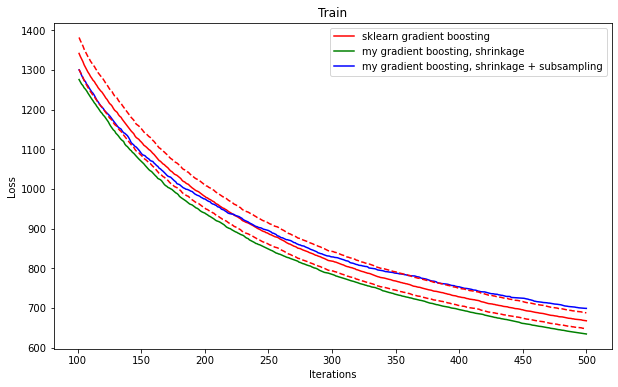

In [34]:
plot_compare_gb(100, sk_train_loglosses, my_train_loglosses0, my_train_loglosses1, "Train")

sklearn logloss = 0.3059
threshold 3% = 0.2967...0.3150
my logloss, shrinkage = 0.2947
my logloss, shrinkage + subsampling = 0.2992


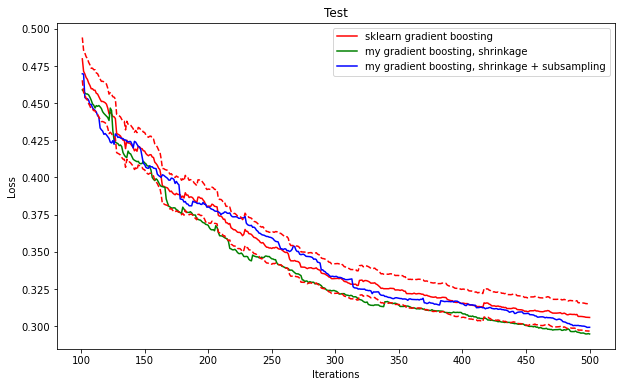

In [35]:
N_ESTIMATORS = 500
base_test_score = np.zeros(N_ESTIMATORS)
my_test_score0 = np.zeros(N_ESTIMATORS)
my_test_score1 = np.zeros(N_ESTIMATORS)

for i, y_pred in enumerate(clf_gb_sklearn.staged_decision_function(X_test)):
    base_test_score[i] = clf_gb_sklearn.loss_(y_test, y_pred)
for i, y_pred in enumerate(my_gb0.staged_decision_function(X_test)):
    my_test_score0[i] = my_gb0.sklearn_loss(y_test, y_pred)
for i, y_pred in enumerate(my_gb1.staged_decision_function(X_test)):
    my_test_score1[i] = my_gb1.sklearn_loss(y_test, y_pred)  

plot_compare_gb(100, base_test_score, my_test_score0, my_test_score1, "Test")    

sklearn logloss = 1537.8361
threshold 3% = 1491.7010...1583.9712
my logloss, shrinkage = 1481.9554
my logloss, shrinkage + subsampling = 1504.5270


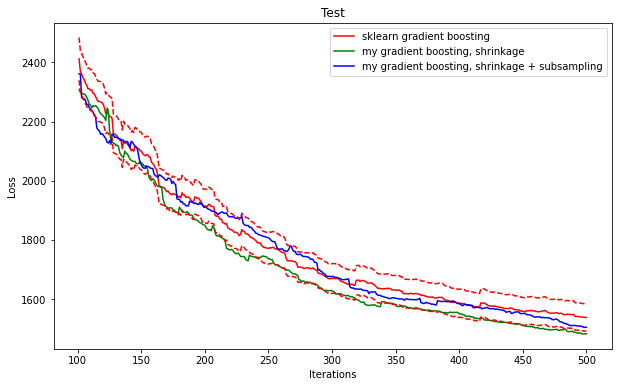

In [36]:
plot_compare_gb(100, sk_test_loglosses, my_test_loglosses0, my_test_loglosses1, "Test")    